In [21]:
import numpy as np
from dsp.pll import PLL_2
from dsp.fir import WSFilter
from dsp.decoding import SymbolDecoder
from dsp.agc import AGC
from dsp.am import AMDemodulator
from exp_utils import read_real, plot_some, plot_several, welch

In [22]:
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join
root_path = os.getenv('RADIO_PATH', '.')

In [23]:
# source: rtl_fm -M fm -s 171000 -f 104105000
# TODO: load amplitude demodulation results
data_path = join(root_path, 'data/rds_am_demodulated.npy')
rds_demod = read_real(data_path, dtype=np.int16).astype(np.double)

Well, let's try something simple first - a plain sinusoid will do.

In [24]:
n_samples = 10 ** 5

# message signal parameters
A_m = 1
f_dev = 1
f_m = 2375
f_ms = 171000
phi_m = 0
phi_mod = np.array([(1 + np.cos(2 * np.pi * f_dev / f_ms * n)) for n in range(n_samples)])

# msg_samples = np.array([A_m * np.cos(2 * np.pi * f_m / f_ms * n + phi_m) for n in range(n_samples)])
msg_samples = np.array([A_m * np.cos(2 * np.pi * f_m / f_ms * n + phi_mod[n]) for n in range(n_samples)])

In [25]:
symbol_rate = 2375
sample_rate = 171000
samples_per_symbol = sample_rate / symbol_rate
output_samples_per_symbol = 2
symbol_delay = 3
filterbank_size = 32
matched_filter_rolloff = 0.8
Bn = 0.01

sd = SymbolDecoder(
    sample_rate,
    samples_per_symbol,
    output_samples_per_symbol,
    nco_gain=12,
    symbol_delay=symbol_delay,
    filterbank_size=filterbank_size, 
    matched_filter_rolloff=matched_filter_rolloff,
    Bn=Bn
)

In [26]:
symbols, xs, taus, tau_deltas = sd.run(msg_samples)

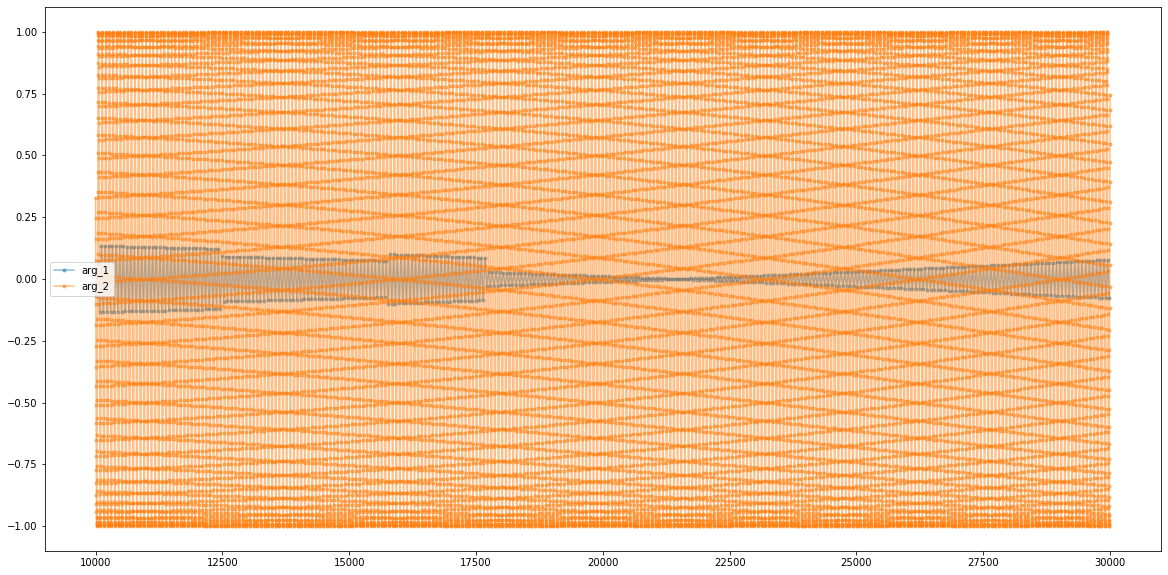

In [27]:
start = 10000
count = 20000
start_s = np.searchsorted(xs, start)
count_s = np.searchsorted(xs, start + count) - start_s

plot_several([
    (xs, 5 * symbols, (start_s, count_s)),
    # (xs, 4 * np.sign(symbols), (start_s, count_s)),
    (msg_samples, (start, count)),
    # (xs, taus, (start_s, count_s)),
    # (xs, tau_deltas / 35, (start_s, count_s))
], '.-')

In [28]:
symbols.shape

(2778,)

Now on to the real signal.

BTW, it might again bo helpful to apply AGC to the pulse-shaped message signal.

In [29]:
from dsp.agc import AGC
gain = 0.08
alpha = 0.11
agc = AGC(gain, alpha)
msg_agc = agc.run(rds_demod)

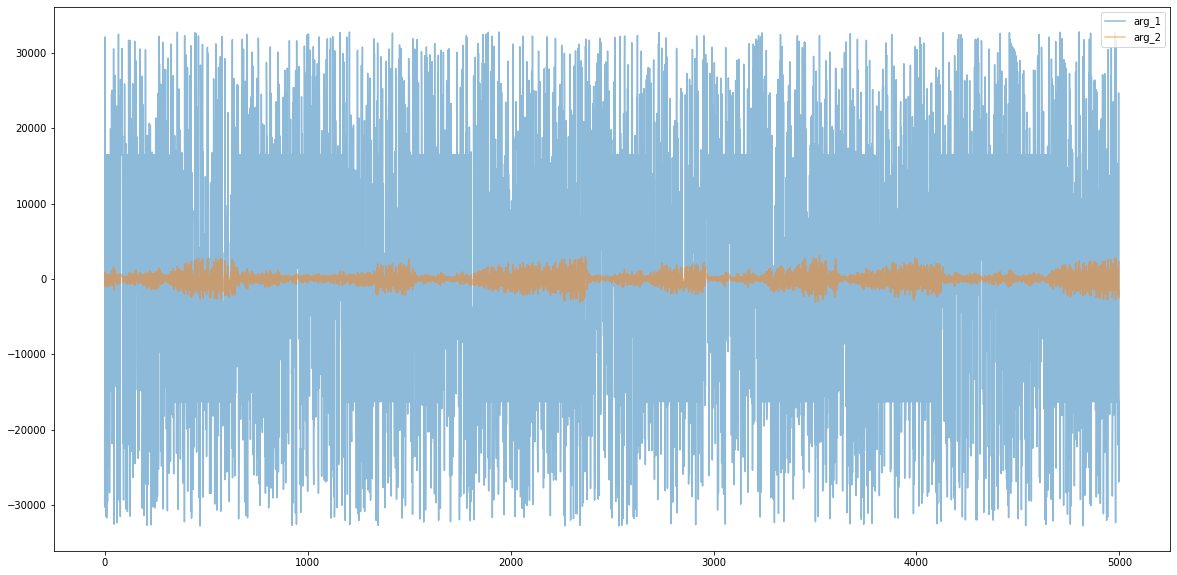

In [30]:
plot_some([rds_demod, 100 * msg_agc], 50000, 5000)

In [31]:
symbol_rate = 2375
sample_rate = 171000
samples_per_symbol = sample_rate / symbol_rate
output_samples_per_symbol = 1
symbol_delay = 3
filterbank_size = 32
matched_filter_rolloff = 0.8
Bn = 0.01

sd = SymbolDecoder(
    sample_rate,
    samples_per_symbol,
    output_samples_per_symbol,
    nco_gain=1,
    symbol_delay=symbol_delay,
    filterbank_size=filterbank_size, 
    matched_filter_rolloff=matched_filter_rolloff,
    Bn=Bn
)

In [32]:
symbols, xs, taus, tau_deltas = sd.run(msg_agc)
xs.shape

(90132,)

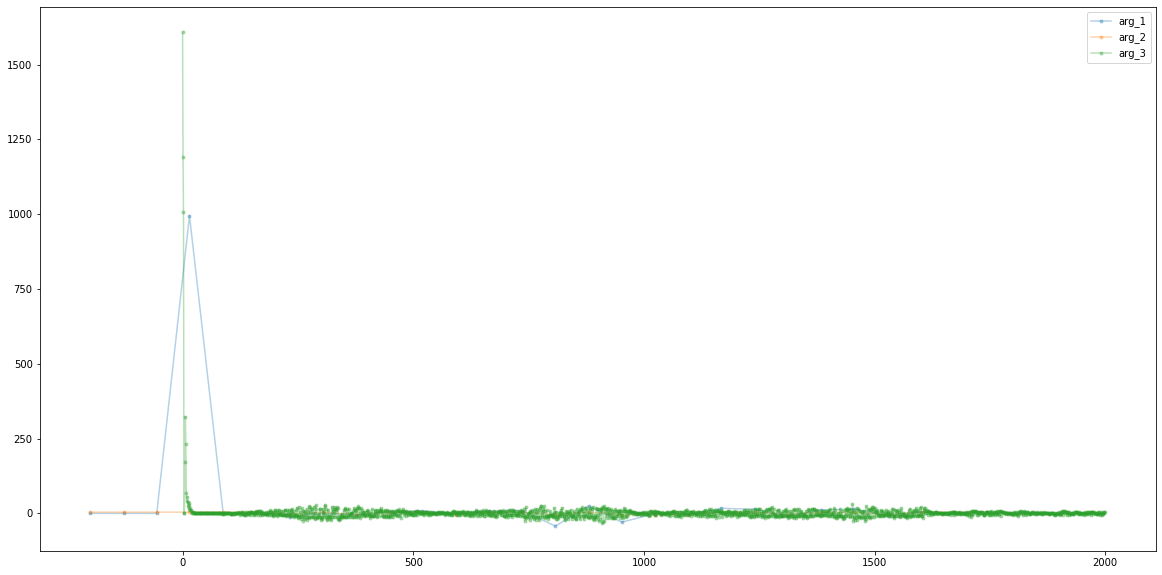

In [33]:
start = 0
count = 2000

start_s = np.searchsorted(xs, start)
count_s = np.searchsorted(xs, start + count) - start_s

plot_several([ 
    (xs - 200, 50 * symbols, (start_s, count_s)),   # why 200??
    (xs - 200, 4 * np.sign(symbols), (start_s, count_s)),
    # (rds_demod, (start, count)),
    (msg_agc, (start, count)),
    # (xs, taus, (start_s, count_s)),
    # (xs, tau_deltas / 35, (start_s, count_s))
], '.-')

In [34]:
rds_bits = np.sign(symbols)

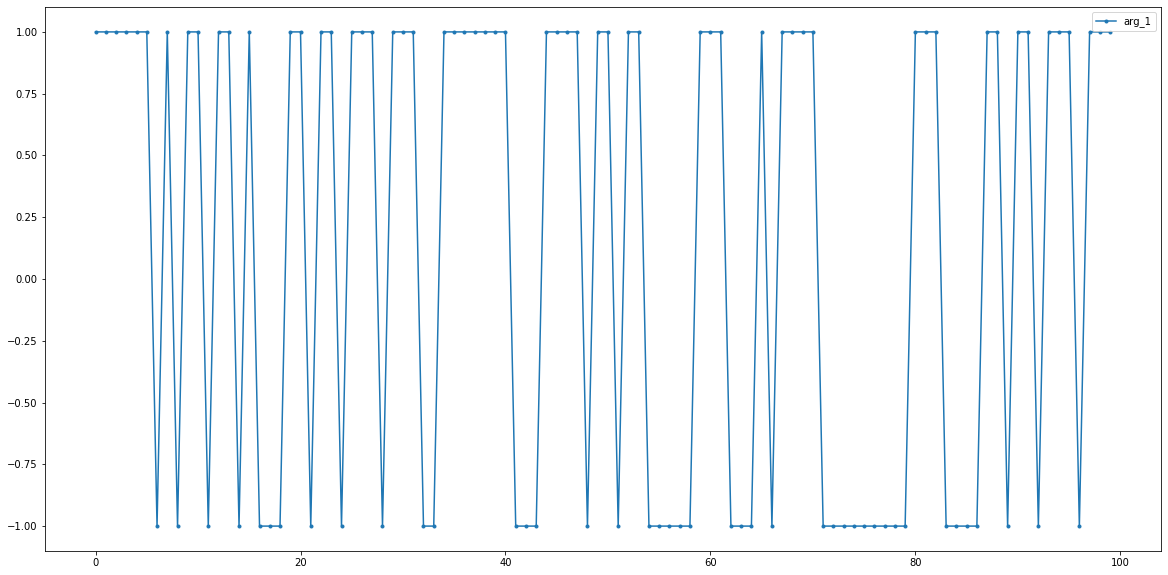

In [35]:
plot_some((rds_bits, ), 0, 100, '.-')

### Notes:
 * changing B\_n leads to a weird shift between chosen points and actual rds (the bigger the B\_n, the fewer returned symbols...)
 * ...

In [36]:
np.save(join(root_path, 'data/rds_physical_bits'), rds_bits)